In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use(r'mplstyle')

import matplotlib as mpl
import pandas as pd
from sklearn.svm import SVC
from scipy.optimize import curve_fit
from sklearn.utils import resample
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import ScaledTranslation
from scipy.optimize import minimize
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fed9ae', '#fbad54']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [2]:
def fit_svc(data, label):
    svc = SVC(kernel = 'linear', class_weight = 'balanced')
    svc.fit(data, label)
    w = svc.coef_[0]           # w consists of 2 elements
    a = - svc.intercept_[0] / w[1]
    b = - w[0] / w[1] 
    return a, b

def analyse_loglog_data(xx, yy, label, repeats = 50, nsample = 5000):
    # fit power law
    lnx = np.log10(xx)
    lny = np.log10(yy)
    data = np.array([lnx, lny]).T
    
    molar_ratio = []
    B = []
    A = []
    for _ in range(repeats):
        print(_, end = '\r')
        data_resampled, label_resampled = resample(data, label, replace = True, n_samples = min(nsample, len(data)))
        a, b = fit_svc(data_resampled, label_resampled)
        # a, b = fit_crosstalk(data_resampled, label_resampled, x0 = [b, a])
        molar_ratio.append(-1/b)
        B.append(b)
        A.append(a)
    molar_ratio_avg = np.mean(molar_ratio)
    molar_ratio_std = np.std(molar_ratio)
    B_avg = np.mean(B)
    B_std = np.std(B)
    A_avg = np.mean(A)
    A_std = np.std(A)
    
    return [molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std]

def plot_loglog_data(fig, axes, xx, yy, cc, xlim_lin, xlim_log, ylim_lin, ylim_log, xlabel, ylabel, res):
    [molar_ratio_avg, molar_ratio_std, A_avg, A_std, B_avg, B_std] = res
    
    axes.scatter(xx, yy, c = cc, s = 2)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    
    x_fit = np.linspace(1e-2, 1e2, 1000)
    y_fit_avg = 10 ** A_avg * x_fit ** B_avg
    y_fit_iter = []
    for _1 in [-1, +1]:
        for _2 in [-1, +1]:
            y_fit_iter.append(10 ** (A_avg + _1 * A_std) * x_fit ** (B_avg + _2 * B_std))
    y_fit_max = np.max(y_fit_iter, axis = 0)
    y_fit_min = np.min(y_fit_iter, axis = 0)
    
    axes.plot(x_fit, y_fit_avg, color = 'black', lw = 1)
    axes.plot(x_fit, y_fit_min, color = 'black', lw = 1, linestyle = 'dashed')
    axes.plot(x_fit, y_fit_max, color = 'black', lw = 1, linestyle = 'dashed')
    # axes.fill_between(x_fit, y_fit_min, y_fit_max, color = 'black', alpha = 0.1, linewidth = 0)

    axes.set_xscale('log')
    axes.set_yscale('log')

    axes.set_xlim(*xlim_log)
    axes.set_ylim(*ylim_log)

    ax_inset = inset_axes(axes, width="70%", height="70%", loc=3, bbox_to_anchor=(.23, .19, .6, .6),
                   bbox_transform=axes.transAxes)
    
    ax_inset.scatter(xx, yy, c = cc, s = 2)
    ax_inset.plot(x_fit, y_fit_avg, color = 'black', lw = 1)
    # ax_inset.fill_between(x_fit, y_fit_min, y_fit_max, color = 'black', alpha = 0.1)
    ax_inset.plot(x_fit, y_fit_min, color = 'black', lw = 1, linestyle = 'dashed')
    ax_inset.plot(x_fit, y_fit_max, color = 'black', lw = 1, linestyle = 'dashed')

    ax_inset.set_xlim(*xlim_lin)
    ax_inset.set_ylim(*ylim_lin)
    ax_inset.set_xlabel(xlabel)
    ax_inset.set_ylabel(ylabel)
    ax_inset.set_xticks(np.linspace(*xlim_lin, 3))
    ax_inset.set_yticks(np.linspace(*ylim_lin, 3))
    
    # axes[0].annotate(r'$\frac{q^{\text{FUS(G156E)}}}{q^{\text{PEG6k}}}\approx0.56$', xy=(2e-1,3e0))

In [3]:
dfs = []
key = []
lab = []
subtitles = ['P113', 'OS-C', 'Buforin-2']

dfs.append(pd.read_csv('../data/AMP_P113.csv').sample(frac = 1))
key.append([r'PolyA, ng/uL', r'P113, uM'])
lab.append([r'[RNA](ng/ul)', r'[AMP](uM)'])

dfs.append(pd.read_csv('../data/AMP_Os-C.csv').sample(frac = 1))
key.append([r'PolyA, ng/uL', r'Os-C, uM'])
lab.append([r'[RNA](ng/ul)', r'[AMP](uM)'])

dfs.append(pd.read_csv('../data/AMP_Buforin-2.csv').sample(frac = 1))
key.append([r'PolyA, ng/uL', r'Buforin-2, uM'])
lab.append([r'[RNA](ng/ul)', r'[AMP](uM)'])

In [4]:
# extracting phase boundary
PS = []
RNAbins = np.linspace(100, 1500, 40)
AMPbins = np.linspace(0, 200, 40)
dRNA = RNAbins[1] - RNAbins[0]
dAMP = AMPbins[1] - AMPbins[0]

for i in range(3):
    _df = dfs[i]
    _x = _df[key[i][0]].values
    _y = _df[key[i][1]].values
    ps = np.zeros((len(RNAbins), len(AMPbins)))
    for j in range(len(RNAbins)):
        print(f'{i}-{j:02d}', end = '\r')
        for k in range(len(AMPbins)):
            mask = ((RNAbins[j] - dRNA/2 < _x) & (_x < RNAbins[j] + dRNA/2) &
                    (AMPbins[k] - dAMP/2 < _y) & (_y < AMPbins[k] + dAMP/2))
            if len(mask) > 0:
                ps[j, k] = np.mean(_df['feature'].values.astype(int)[mask])
    PS.append(ps)

1-09

/Users/dq219/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dq219/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


2-39

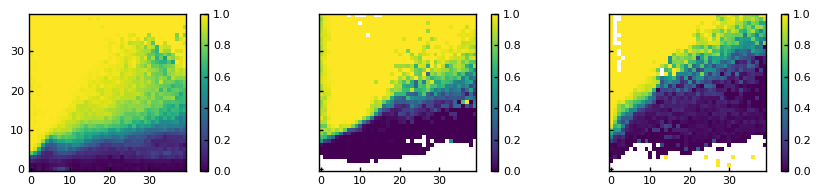

In [5]:
RR, AA = np.meshgrid(RNAbins, AMPbins)
COORS = []
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (9, 2))
ims = []
for i in range(3):
    ps = PS[i].T
    ims.append(axes[i].imshow(ps, origin='lower'))
    mask = (0.3 < ps) & (ps < 0.7)
    xx = RR[mask]
    yy = AA[mask]
    COORS.append([xx, yy])
for i in range(3):
    fig.colorbar(ims[i], ax=axes[i])
plt.tight_layout()

In [6]:
def fitFun(x, b, c):
    return 30 * np.exp(b * c * (1 - np.exp( - x / c)))

[6.79947667e-04 6.61348630e+06]
[1.00857376e-04 1.06010459e+10]
[2.88522462e-03 4.72975435e+02]
[2.63118362e-04 5.56596406e+01]
[3.64783078e-03 4.86843778e+02]
[1.57213728e-04 2.79457139e+01]


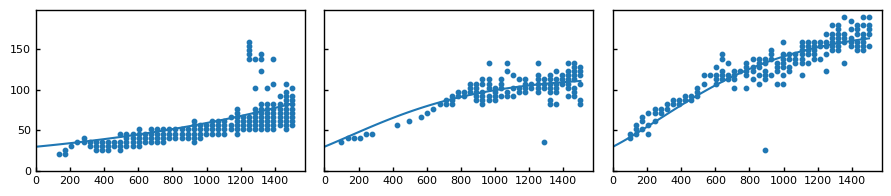

In [7]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize = (9, 2))

xx = np.linspace(0, 1500)
PARA = []
ERRO = []
for i in range(3):
    _x = COORS[i][0]
    _y = COORS[i][1]
    
    popt, pcov = curve_fit(fitFun, _x, _y, p0 = (1/500, 500))
    print(popt)
    print(np.sqrt(np.diag(pcov)))
    PARA.append(popt)
    ERRO.append(np.sqrt(np.diag(pcov)))
    
    axes[i].scatter(_x, _y, s = 10)
    axes[i].plot(xx, fitFun(xx, *popt))
plt.ylim(0)
plt.xlim(0)
plt.tight_layout()


PARA = np.array(PARA)
ERRO = np.array(ERRO)

In [8]:
# save scatter PhaseScan data as pngs, otherwise the .pdfs blow up in size :O
for i in range(3):
    plt.figure(figsize=(5.6,6))
    _df = dfs[i]
    _x = _df[key[i][0]].values
    _y = _df[key[i][1]].values
    _p = _df['feature'].values
    _c = [colors[0][j] for j in _p.astype(int)]
    plt.scatter(_x, _y, c = _c, s = 40)
    plt.xlim(0,1500)
    plt.ylim(0, 200)
    plt.axis('off')
    plt.savefig(f'plots/AMP_PhaseScan_{i}.png', bbox_inches='tight', pad_inches=0, dpi = 300)
    plt.close()

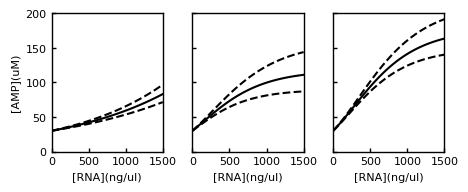

In [9]:
fig, axes = plt.subplots(1, 3, figsize = cm2inch(12, 5), sharex = True, sharey = True)
for i in range(3):
    
    # _df = dfs[i]
    # _x = _df[key[i][0]].values
    # _y = _df[key[i][1]].values
    # _p = _df['feature'].values
    # _c = [colors[0][j] for j in _p.astype(int)]
    # axes[i].scatter(_x, _y, c = _c, s = 2)
    
    [pB, pC] = PARA[i]
    [dB, dC] = ERRO[i]

    y_fit_avg = fitFun(xx, pB, pC)
    y_fit_iter = []
    for _1 in [-1, +1]:
        for _2 in [-1, +1]:
            y_fit_iter.append(fitFun(xx, pB + _1 * dB, pC + _2 * dC))
    y_fit_max = np.max(y_fit_iter, axis = 0)
    y_fit_min = np.min(y_fit_iter, axis = 0)

    axes[i].plot(xx, y_fit_avg, color = 'black')
    axes[i].plot(xx, y_fit_max, color = 'black', linestyle = 'dashed')
    axes[i].plot(xx, y_fit_min, color = 'black', linestyle = 'dashed')

    axes[i].set_xlabel(lab[i][0])
    
axes[0].set_ylabel(lab[i][1])
axes[0].set_xlim(0,1500)
axes[0].set_ylim(0, 200)
plt.tight_layout()
plt.savefig('plots/AMP_fitting.pdf')

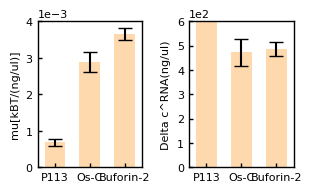

In [10]:
fig, axes = plt.subplots(1, 2, figsize = cm2inch(8, 5), sharex = True)

for i in range(2):
    vv = PARA[:, i]
    ve = ERRO[:, i]
    if i == 1:
        vv[0] = 1000 # constrain this value - this is effectively infinity
        ve[0] = 0
    axes[i].bar(np.arange(3), vv, yerr = ve, capsize = 5, color = colors[2][0], width = 0.6)
    axes[i].set_xticks(np.arange(3), [r'P113', r'Os-C', r'Buforin-2'])
axes[0].set_ylim(0, 0.004)
axes[1].set_ylim(0, 600)
axes[0].set_xlim(-0.5, 2.5)
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(-3,-3))
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(2,2))

axes[0].set_ylabel(r'mu[kBT/(ng/ul)]')
axes[1].set_ylabel(r'Delta c^RNA(ng/ul)')

plt.tight_layout()
plt.savefig('plots/AMP_barplot.pdf')